In [3]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

from autoencoder import Autoencoder
import umap
from sklearn.decomposition import PCA
from collections import defaultdict

In [2]:
model = Autoencoder.load_from_checkpoint('/home/artem/dev/CBIR-v2/models/context_encoder/checkpoints/bs64_nf8_nz2048_convs_in_block_1.ckpt')
_ = model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
  )
  (4): Sequential(
    (0): Conv2d(6

In [4]:
MEAN = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)
STD = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)

denormalization = transforms.Normalize((-MEAN / STD).tolist(), (1.0 / STD).tolist())

In [20]:
class FolderDataset(Dataset):
    def __init__(self, data_dir, load_fn, transform_fn):
        self.data_dir = data_dir
        self.data = os.listdir(data_dir)
        self.load_fn = load_fn
        self.transform_fn = transform_fn

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        file_path = os.path.join(self.data_dir, img_path)
        loaded = self.load_fn(file_path)
        transformed = self.transform_fn(loaded)
        
        meta = {}
        name_split = img_path.split('_')
        meta['class'] = name_split[1]
        meta['superclass'] = name_split[2]
        
        return transformed, meta

transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(MEAN.tolist(), STD.tolist()),
    ]
)

val_dataset = FolderDataset(data_dir=f'{os.getenv("HOME")}/data/COCO/CBIR_data/val',
                            load_fn=np.load,
                            transform_fn=transform)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=4
)

In [21]:
TARGET_CLASSES = set([
    'banana',
    'broccoli',
    'giraffe',
    'person',
    'zebra'
])

In [22]:
features = defaultdict(list)

for idx, (batch, meta) in tqdm(enumerate(val_dataloader)):  
    classes = meta['class']
    batch_features = model.encoder(batch).cpu().detach()
    for i in range(batch_features.shape[0]):
        cur_featuers = batch_features[i, :, 0, 0]
        features[classes[i]].append(np.array(cur_featuers))

94it [00:03, 24.83it/s]


In [25]:
all_features = []
all_cats = []
idx_to_cat = {}
for i, target_class in enumerate(TARGET_CLASSES):
    idx_to_cat[i] = target_class
    for elem in features[target_class]:
        all_features.append(elem)
        all_cats.append(i)

pca = PCA(n_components=512).fit(all_features)
all_features = pca.transform(all_features)
        
manifold = umap.UMAP(random_state=24).fit(all_features, all_cats)
all_features_umap = manifold.transform(all_features)

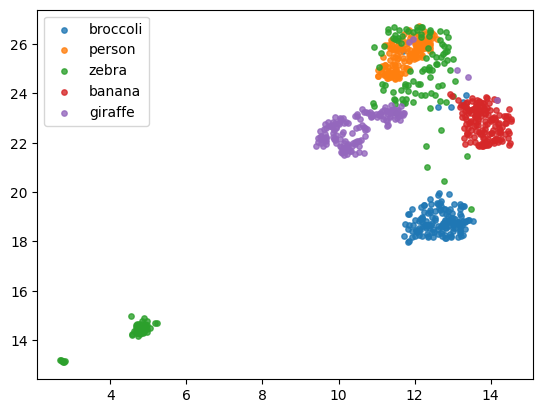

In [26]:
x = defaultdict(list)
y = defaultdict(list)

for i in range(len(all_features)):
    cat = idx_to_cat[all_cats[i]]
    dot = all_features_umap[i]
    x[cat].append(dot[0])
    y[cat].append(dot[1])
    
for cat in TARGET_CLASSES:
    plt.scatter(x[cat], y[cat], label=cat, s=15, alpha=0.8)

plt.legend()
plt.show()

In [16]:
from torch.hub import load_state_dict_from_url

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block=Bottleneck, layers=None, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, hps=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward
    
resnet50 = ResNet(Bottleneck, [3, 4, 6, 3])
arch = 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
state_dict = load_state_dict_from_url(arch, progress=True)
resnet50.load_state_dict(state_dict, strict=False)
resnet50 = nn.Sequential(*list(resnet50.children())[:-2])
resnet50 = resnet50.eval()

In [17]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(MEAN.tolist(), STD.tolist()),
    ]
)

val_dataset = FolderDataset(data_dir=f'{os.getenv("HOME")}/data/COCO/CBIR_data/val',
                            load_fn=np.load,
                            transform_fn=transform)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=4
)

In [18]:
features = defaultdict(list)

for idx, (batch, meta) in tqdm(enumerate(val_dataloader)):  
    classes = meta['class']
    batch_features = resnet50(batch).cpu().detach()
    for i in range(batch_features.shape[0]):
        cur_featuers = batch_features[i, :, 0, 0]
        features[classes[i]].append(np.array(cur_featuers))

94it [01:53,  1.20s/it]


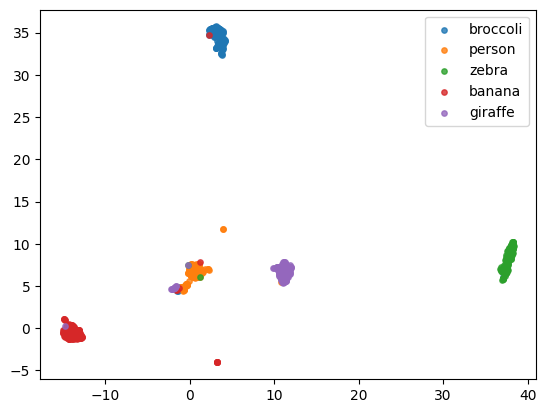

In [19]:
all_features = []
all_cats = []
idx_to_cat = {}
for i, target_class in enumerate(TARGET_CLASSES):
    idx_to_cat[i] = target_class
    for elem in features[target_class]:
        all_features.append(elem)
        all_cats.append(i)

# pca = PCA(n_components=512).fit(all_features)
# all_features = pca.transform(all_features)
        
manifold = umap.UMAP(random_state=24).fit(all_features, all_cats)
all_features_umap = manifold.transform(all_features)

x = defaultdict(list)
y = defaultdict(list)

for i in range(len(all_features)):
    cat = idx_to_cat[all_cats[i]]
    dot = all_features_umap[i]
    x[cat].append(dot[0])
    y[cat].append(dot[1])
    
for cat in TARGET_CLASSES:
    plt.scatter(x[cat], y[cat], label=cat, s=15, alpha=0.8)

plt.legend()
plt.show()